In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, roc_auc_score
import torch
import torch.nn as nn
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset
from sklearn.model_selection import StratifiedKFold
import warnings
import random

warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn._oldcore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


According to data from the Federal Trade Commision there were 117,000 cases of credit card fraudin the United States in the third quarter of 2024 alone, and this number is rising, 65% of people have also experienced card fraud at least once. This project will involve trying to detect credit card fraud. We will use a dataset containing transactions made by european cardholders in 2013. Due to confidentiality there are no sources and most features are anonymized. This means we will focus on using unsupervised learning techniques to extract meaningful information. 

We will start by showcasing the first few rows of the dataset.

In [4]:
df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The dataset mainly contains numerical and numbered "V" features that are the result of PCA dimensionality reduction. PCA is a statistical technique used to reduce a large amount of variables into a single one that still contains the important patterns and relations between the variables.

There is a "Time" feature which denotes the amount of time that has passed since the first transactions.

The "Amount" feature indicates the financial amount that was exchanged during the transaction.

Finally the "Class" feature classified whether the transaction was fradulent or not, "1" indicating fradulence and "0" not indicating it.

We will now display the size of the dataset in terms of the number of rows, columns, and the amount of disk space the data consists of.

In [5]:
n_rows = len(df)
n_cols = df.shape[1]
memory_usage = df.memory_usage(deep=True).sum()

print(f"Train dataset: {n_rows} rows × {n_cols} columns")
print(f"Train dataset size: {memory_usage / 1024:.2f} KB")

Train dataset: 284807 rows × 31 columns
Train dataset size: 68976.82 KB


The dataset seems relatively large and has a lot of data, we will likely want to investigate which of the 31 columns are correlated with the "Class" column. To do so we should make sure the dataset is clean first so that we can draw accurate conclusions. We can do this through methods such as removing duplicate values, filling in missing values with medians.

Getting rid of extreme outliers that can overly skew and bias our results is usually important but we should be very careful about doing so with fraud detection since it is very likely that a fraudulent transaction would be for a significant price amount, therefore we will not do any outlier detection.

Likewise we will not engage in data type munging or scaling since the dataset has already gone through a PCA process meaning it has most likely already been scaled and data types have already been set as floating point variables, in short the dataset is already pre-processed. 

Feature engineering will also not be used since the PCA features will already capture maximum variance, and discarding features through analyzing metrics such as correlation and ANOVA score risks missing subtle indicators or features with low individual correlation but that might reveal something in combination with other features.

In [6]:
# Remove duplicate rows
df_clean = df.drop_duplicates()
print(f"After removing duplicates: {df_clean.shape} (removed {len(df) - len(df_clean)} rows)")

#Detect missing values
missing_values = df_clean.isnull().sum()
print(f"Missing values: {missing_values.sum()}")

After removing duplicates: (283726, 31) (removed 1081 rows)
Missing values: 0


We found a few duplicate rows and they were removed, and it seems there were no missing values, meaning the dataset is already mostly clean. Next we should investigate how balanced the dataset is by visualizing how many transactions are fraudulent versus non-fraudulent.

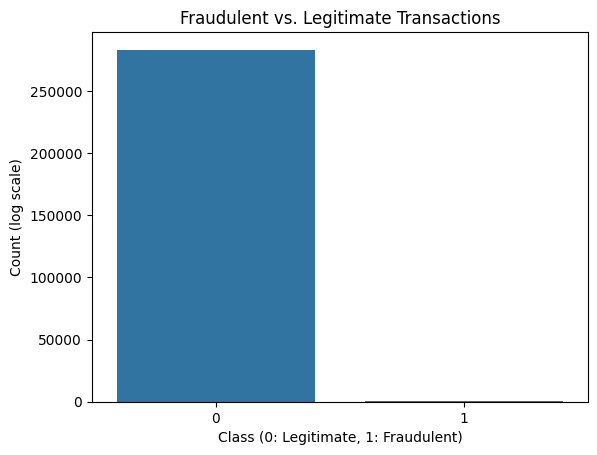


Summary Statistics:
Total transactions: 284807
Legitimate transactions: 283253 (99.45%)
Fraudulent transactions: 473 (0.17%)


In [7]:
sns.countplot(x='Class', data=df_clean, palette=['#1f77b4', '#d62728'])

# Separate legitimate and fraudulent transactions
legitimate = df_clean[df_clean['Class'] == 0]
fraudulent = df_clean[df_clean['Class'] == 1]

# Add labels for clarity
plt.title('Fraudulent vs. Legitimate Transactions')
plt.xlabel('Class (0: Legitimate, 1: Fraudulent)')
plt.ylabel('Count (log scale)')
plt.show()

# Print summary
print("\nSummary Statistics:")
print(f"Total transactions: {len(df)}")
print(f"Legitimate transactions: {len(legitimate)} ({len(legitimate)/len(df)*100:.2f}%)")
print(f"Fraudulent transactions: {len(fraudulent)} ({len(fraudulent)/len(df)*100:.2f}%)")

As we can see the dataset is very imbalanced, with most rows by far favoring legitimate transactions over non-legitimate ones. This will make training a classification model very difficult because it can for example achieve a 99%+ accuracy simply by labeling all transactions as legitimate, which is not a very useful outcome. Therefore we will instead focus on using unsupervised anomaly detection models that specialize in finding outliers.

As an extra note if we did want to implement supervised learning for this dataset we would want to achieve a ratio leaning more towards fraudulent cases in the training data to achieve optimal model outcomes, two common ways of doing this is over and under-sampling. Over-sampling adds copies of the under-represented class (in this case fraudulent cases) and is most useful when you have little data. Under-sampling on the other hand deletes copies of the over-represented class and is more useful when you have plenty of data. We would want to use the SMOTE method of over-sampling which creates synthetic data and also some moderate under-sampling to reduce the gap between legitimate and fraudulent transactions.

Now that we have examined the "Class" parameter we should also investigate the "Time" and "Amount" parameters, we will visualize the their distribution for both legitimate and fraudulent cases.

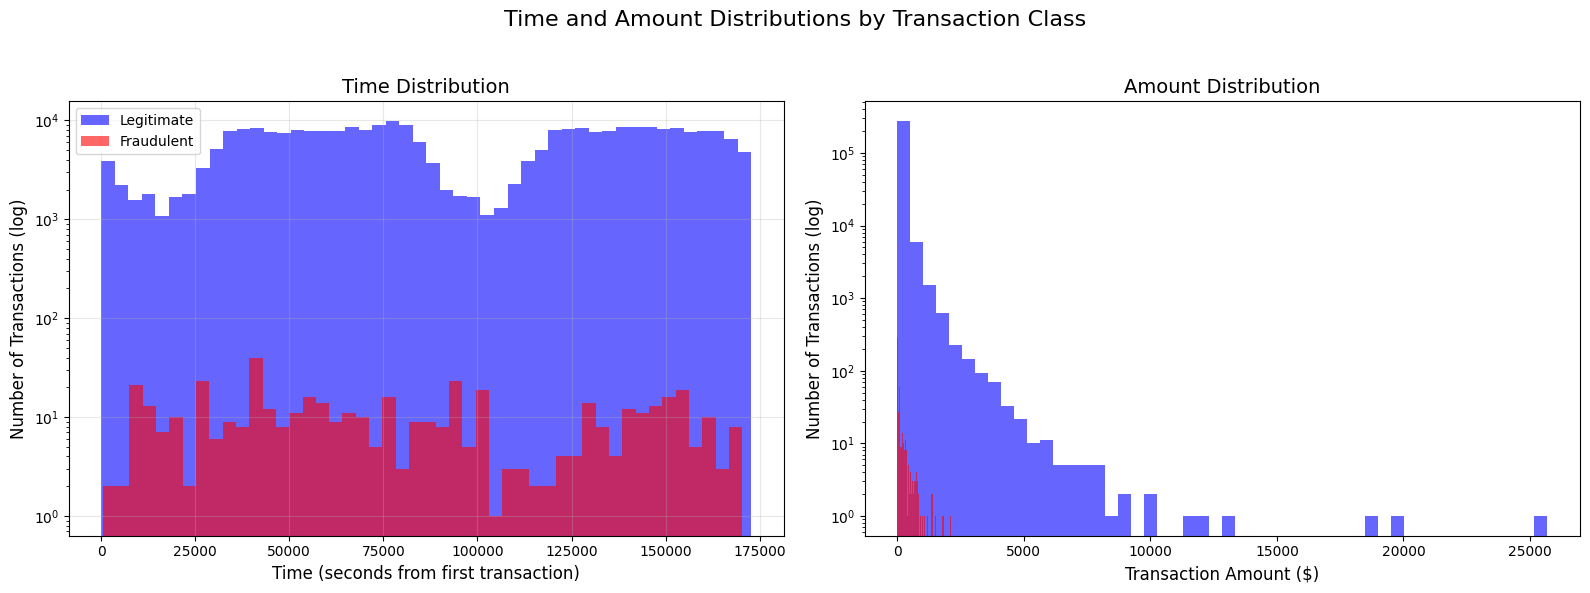


Amount Statistics:
Legitimate transactions average: $88.41
Fraudulent transactions average: $123.87
Legitimate transactions median: $22.00
Fraudulent transactions median: $9.82
Legitimate transactions max: $25691.16
Fraudulent transactions max: $2125.87

Time Statistics:
Legitimate transactions average time: 94835.06 seconds
Fraudulent transactions average time: 80450.51 seconds
Legitimate transactions median time: 84711.00 seconds
Fraudulent transactions median time: 73408.00 seconds
Legitimate transactions max time: 172792.00 seconds
Fraudulent transactions max time: 170348.00 seconds


In [8]:
# Create a figure with 2 subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Time and Amount Distributions by Transaction Class', fontsize=16)

# Time Distribution
axes[0].hist(legitimate['Time'], bins=48, alpha=0.6, color='blue', label='Legitimate')
axes[0].hist(fraudulent['Time'], bins=48, alpha=0.6, color='red', label='Fraudulent')
axes[0].set_title('Time Distribution', fontsize=14)
axes[0].set_xlabel('Time (seconds from first transaction)', fontsize=12)
axes[0].set_ylabel('Number of Transactions (log)', fontsize=12)
axes[0].set_yscale('log')  # Set log scale for y-axis
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Amount Distribution
axes[1].hist(legitimate['Amount'], bins=50, alpha=0.6, color='blue', label='Legitimate')
axes[1].hist(fraudulent['Amount'], bins=50, alpha=0.6, color='red', label='Fraudulent')
axes[1].set_title('Amount Distribution', fontsize=14)
axes[1].set_xlabel('Transaction Amount ($)', fontsize=12)
axes[1].set_ylabel('Number of Transactions (log)', fontsize=12)
axes[1].set_yscale('log')  # Set log scale for y-axis

# Adjust layout and show the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Extract the series into variables
legitimate_amount = legitimate['Amount']
fraudulent_amount = fraudulent['Amount']
legitimate_time = legitimate['Time']
fraudulent_time = fraudulent['Time']

# Print summary statistics
print("\nAmount Statistics:")
print(f"Legitimate transactions average: ${legitimate_amount.mean():.2f}")
print(f"Fraudulent transactions average: ${fraudulent_amount.mean():.2f}")
print(f"Legitimate transactions median: ${legitimate_amount.median():.2f}")
print(f"Fraudulent transactions median: ${fraudulent_amount.median():.2f}")
print(f"Legitimate transactions max: ${legitimate_amount.max():.2f}")
print(f"Fraudulent transactions max: ${fraudulent_amount.max():.2f}")

print("\nTime Statistics:")
print(f"Legitimate transactions average time: {legitimate_time.mean():.2f} seconds")
print(f"Fraudulent transactions average time: {fraudulent_time.mean():.2f} seconds")
print(f"Legitimate transactions median time: {legitimate_time.median():.2f} seconds")
print(f"Fraudulent transactions median time: {fraudulent_time.median():.2f} seconds")
print(f"Legitimate transactions max time: {legitimate_time.max():.2f} seconds")
print(f"Fraudulent transactions max time: {fraudulent_time.max():.2f} seconds")

It seems that fraudulent transactions on average are for a higher amount but actually have a lower median value which implies that most of fraudulent transactions will be for low amounts but that they will slip in some transactions that are higher than average.

The time statistics don't seem to have any notable differences to me which implies that the identity thieves are fairly adept at not creating any obvious chronological patterns for their behaviour, however an unsupervised model might be able to gleam more insight from this than a human can.

We are now done investigating the labeled parameters and will now simply drop them to enable unsupervised training, along with creating a test/training split.

In [9]:
# Set random seed
np.random.seed(42)
torch.manual_seed(42)

# Drop Time, Amount, and Class columns to enable unsupervised learning
X_unsupervised = df_clean.drop(['Time', 'Amount', 'Class'], axis=1)

# Create training and testing splits
X_train, X_test = train_test_split(X_unsupervised, test_size=0.2, random_state=42)

# Store the original labels for later evaluation
y_true = df_clean['Class'].copy()
y_train, y_test = train_test_split(y_true, test_size=0.2, random_state=42)

# Print dataset information
print(f"Full dataset shape: {X_unsupervised.shape}")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Full dataset shape: (283726, 28)
Training set shape: (226980, 28)
Testing set shape: (56746, 28)


Based on what we have observed from this dataset so far two types of models that spring to mind that could fit this dataset are autoencoders and deep SVDD.

Both are supposed to work well for unsupervised datasets, especially ones that are highly imbalanced and that went through a PCA process such as our dataset. 

The autoencoder works by compressing and reconstructing the transactions, with anomalous transactions being harder to reconstruct and therefore less likely to belong and be legitimate.

Deep SVDD on the other hand creates a decision boundary containing normal transactions with fraudulent transactions falling outside of this boundary.

The structure of our autoencoder consists of an encoder that compresses our 28 PCA dimensions down into a bottleneck of 10 dimensions.

The compression happens through an encoder that has two hidden layers with 20 neurons.

A decoder then attempts to reconstruct the transaction from the encoded dimensions. It uses a hidden layer and an output layer with 20 neurons.

The model uses PyTorch and is trained using Hugging Face's trainer librar. We also implements cross validation.

Training fold 1/3...


Epoch,Training Loss,Validation Loss
1,0.388100,0.358357
2,0.336800,0.322670
3,0.311300,0.314454


Fold 1: Precision=0.0303, Recall=0.8924, F1=0.0586, AUC=0.9503
Training fold 2/3...


Epoch,Training Loss,Validation Loss
1,0.326800,0.321363
2,0.292500,0.293446
3,0.289700,0.288748


Fold 2: Precision=0.0292, Recall=0.8726, F1=0.0565, AUC=0.9663
Training fold 3/3...


Epoch,Training Loss,Validation Loss
1,0.326600,0.311835
2,0.289200,0.290103
3,0.297400,0.283602


Fold 3: Precision=0.0281, Recall=0.8544, F1=0.0545, AUC=0.9648

Cross-validation summary:
Precision: 0.0292 ± 0.0009
Recall: 0.8731 ± 0.0155
F1 Score: 0.0565 ± 0.0017
AUC: 0.9605 ± 0.0072


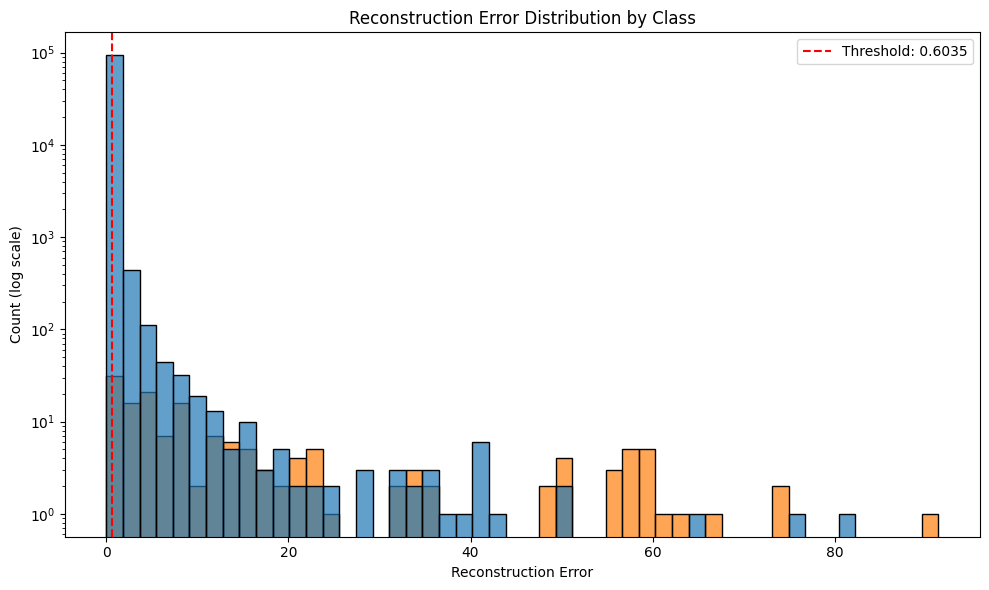

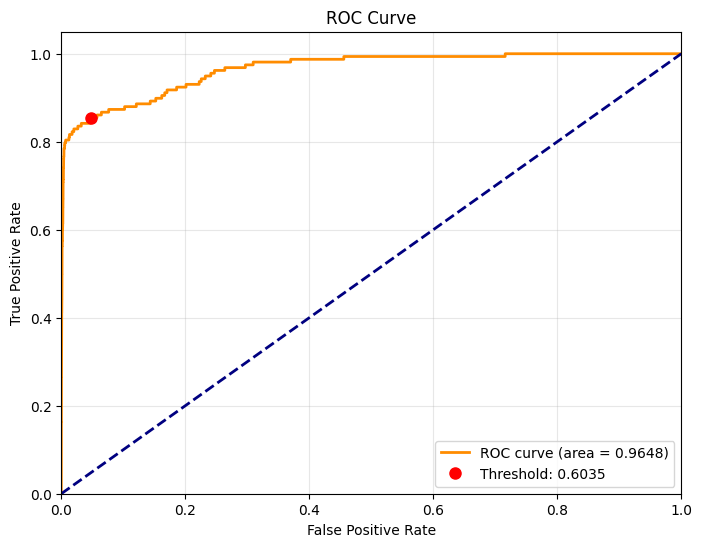

In [29]:
# Define the autoencoder model
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_dim=28, encoding_dim=10):
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 20),
            nn.ReLU(),
            nn.Linear(20, encoding_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 20),
            nn.ReLU(),
            nn.Linear(20, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        reconstruction_error = torch.mean((reconstructed - x) ** 2, dim=1)
        return {
            'reconstructed': reconstructed,
            'reconstruction_error': reconstruction_error
        }

# Dataset class
class AnomalyDataset(Dataset):
    def __init__(self, features):
        if isinstance(features, pd.DataFrame):
            self.features = torch.tensor(features.values, dtype=torch.float32)
        else:
            self.features = torch.tensor(features, dtype=torch.float32)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return {'x': self.features[idx]}

# Custom trainer
class AnomalyTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        x = inputs['x']
        outputs = model(x)
        loss = torch.mean((outputs['reconstructed'] - x) ** 2)
        return (loss, outputs) if return_outputs else loss
    
    def prediction_step(self, model, inputs, prediction_loss_only=False, ignore_keys=None):
        x = inputs['x']
        with torch.no_grad():
            outputs = model(x)
            loss = torch.mean((outputs['reconstructed'] - x) ** 2)
        return loss, outputs['reconstruction_error'], None

# Main cross-validation function
def run_anomaly_detection_cv(X, y, n_splits=3, epochs=3):
    """Run anomaly detection with cross-validation only"""
    
    # Initialize stratified k-fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = {'precision': [], 'recall': [], 'f1': [], 'auc': [], 'threshold': []}
    best_fold_data = {}
    
    # Loop through folds
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"Training fold {fold+1}/{n_splits}...")
        
        # Split data
        if hasattr(X, 'iloc'):  # DataFrame
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        else:  # numpy array
            X_train, X_test = X[train_idx], X[test_idx]
            
        if hasattr(y, 'iloc'):  # Series
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        else:  # numpy array
            y_train, y_test = y[train_idx], y[test_idx]
        
        # Create datasets
        train_dataset = AnomalyDataset(X_train)
        test_dataset = AnomalyDataset(X_test)
        
        # Create model and trainer
        model = SimpleAutoencoder(input_dim=X_train.shape[1])
        
        # Training arguments
        args = TrainingArguments(
            output_dir=f"./anomaly_fold_{fold}",
            num_train_epochs=epochs,
            per_device_train_batch_size=64,
            learning_rate=0.001,
            save_strategy="no",
            eval_strategy="epoch",
            report_to="none",
            disable_tqdm=False
        )
        
        trainer = AnomalyTrainer(
            model=model,
            args=args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
        )
        trainer.train()
        
        # Get reconstruction errors
        train_outputs = trainer.predict(train_dataset)
        test_outputs = trainer.predict(test_dataset)
        train_errors = train_outputs.predictions
        test_errors = test_outputs.predictions
        
        # Find threshold (95th percentile of training errors)
        threshold = np.percentile(train_errors, 95)
        
        # Make predictions
        y_pred = (test_errors > threshold).astype(int)
        
        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, average='binary')
        auc_score = roc_auc_score(y_test, test_errors)
        
        # Store results
        results['precision'].append(precision)
        results['recall'].append(recall)
        results['f1'].append(f1)
        results['auc'].append(auc_score)
        results['threshold'].append(threshold)
        
        # Save best fold data for visualization
        if fold == n_splits - 1 or auc_score > results['auc'][-1] if fold > 0 else 0:
            best_fold_data = {
                'errors': test_errors,
                'y_true': y_test,
                'threshold': threshold
            }
        
        print(f"Fold {fold+1}: Precision={precision:.4f}, Recall={recall:.4f}, " 
              f"F1={f1:.4f}, AUC={auc_score:.4f}")
    
    # Calculate summary statistics
    summary = {}
    for metric in results:
        summary[f'{metric}_mean'] = np.mean(results[metric])
        summary[f'{metric}_std'] = np.std(results[metric])
    print("\nCross-validation summary:")
    print(f"Precision: {summary['precision_mean']:.4f} ± {summary['precision_std']:.4f}")
    print(f"Recall: {summary['recall_mean']:.4f} ± {summary['recall_std']:.4f}")
    print(f"F1 Score: {summary['f1_mean']:.4f} ± {summary['f1_std']:.4f}")
    print(f"AUC: {summary['auc_mean']:.4f} ± {summary['auc_std']:.4f}")
    visualize_results(results, summary, best_fold_data)
    return results, summary

def visualize_results(results, summary, best_fold_data):
    
    # Error distribution
    if best_fold_data:
        # Plot histogram
        plt.figure(figsize=(10, 6))
        results_df = pd.DataFrame({
            'Reconstruction_Error': best_fold_data['errors'],
            'Class': ['Anomaly' if c == 1 else 'Normal' for c in best_fold_data['y_true']]
        })
        
        sns.histplot(data=results_df, x='Reconstruction_Error', hue='Class',
                    bins=50, alpha=0.7, log_scale=(False, True))
        
        plt.axvline(x=best_fold_data['threshold'], color='red', linestyle='--', 
                   label=f'Threshold: {best_fold_data["threshold"]:.4f}')
        
        plt.title('Reconstruction Error Distribution by Class')
        plt.xlabel('Reconstruction Error')
        plt.ylabel('Count (log scale)')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # ROC curve
        fpr, tpr, thresholds = roc_curve(best_fold_data['y_true'], best_fold_data['errors'])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        idx = (np.abs(thresholds - best_fold_data['threshold'])).argmin()
        plt.plot(fpr[idx], tpr[idx], 'ro', markersize=8, 
                 label=f'Threshold: {best_fold_data["threshold"]:.4f}')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()

# Combine train and test data
X_combined = pd.concat([X_train, X_test]) if isinstance(X_train, pd.DataFrame) else np.vstack([X_train, X_test])
y_combined = pd.concat([y_train, y_test]) if isinstance(y_train, pd.Series) else np.concatenate([y_train, y_test])

# Run cross-validation 
results, summary = run_anomaly_detection_cv(X_combined, y_combined)

According to the results of the model only 2,9% of the transactions labelled as being fraudulent actually are, this can be seen in the "precision". We do however catch 87% of fraud cases which can be seen in the "recall" metric. F1 score is the precision to recall tradeoff and is quite low, which is typical for such an imbalanced dataset. Finally the AUC is quite high which means the model is excellent and discriminating between fraud and legitimate transactions.

The error distribution image implies that most legitimate transactions are concentrated at lower error values while the fraudulent ones are ranked higher, which is good, there is also a distinct amount of fraudulent transactions at the higher outliers that have a higher amount of reconstruction errors. Finally the ROC  curve shows excellent discriminative power and strong separation ability.

Overall the model has many false positives but is worth it if investigating many cases is worth it to catch most cases of fraud for a bank.

The main hyperparameters that we are using are threshold, batch size and learning rate. Threshold being a metric where reconstruction error below the threshold are considered to be legitimate while those above are labeled as fraudulent, we will start by setting this to the 95th percentile. 

Batch size is the number of training examples processed in a single model pass, smaller batch sizes mean more frequent weight updates in the neurons, which are computational units in a neural network layer that process input, output and shift internal weight values, but potentially more noise while larger ones mean the opposite. We will start with a moderate batch size of 64 to start with.

Learning rate controls how much the weights will adjust during training with low training weight being slow but stable and high being very fast but potentially overshooting optimal weights.

We will now do some hyperparameter tuning to see if we can achieve some better results. This will consist of picking different values for batch size, threshold and learning rate and seeing if the model performs better.


Testing learning rates...
Learning rate: 0.0001


Epoch,Training Loss,Validation Loss
1,1.000200,0.927235


Metrics: Precision=0.0265, Recall=0.8222, F1=0.0513, AUC=0.9371
Learning rate: 0.001


Epoch,Training Loss,Validation Loss
1,0.363800,0.347602


Metrics: Precision=0.0270, Recall=0.8444, F1=0.0523, AUC=0.9443
Learning rate: 0.01


Epoch,Training Loss,Validation Loss
1,0.220700,0.209547


Metrics: Precision=0.0232, Recall=0.7333, F1=0.0449, AUC=0.9251

Testing batch sizes...
Batch size: 32


Epoch,Training Loss,Validation Loss
1,0.321800,0.278399


Metrics: Precision=0.0248, Recall=0.7889, F1=0.0482, AUC=0.9393
Batch size: 64


Epoch,Training Loss,Validation Loss
1,0.363800,0.347602


Metrics: Precision=0.0270, Recall=0.8444, F1=0.0523, AUC=0.9443
Batch size: 128


Epoch,Training Loss,Validation Loss
1,0.416100,0.424289


Metrics: Precision=0.0259, Recall=0.8333, F1=0.0503, AUC=0.9404

Testing threshold percentiles...


Epoch,Training Loss,Validation Loss
1,0.349700,0.347602


Threshold percentile: 90
Metrics: Precision=0.0135, Recall=0.8556, F1=0.0266, AUC=0.9443
Threshold percentile: 95
Metrics: Precision=0.0270, Recall=0.8444, F1=0.0523, AUC=0.9443
Threshold percentile: 99
Metrics: Precision=0.1140, Recall=0.7333, F1=0.1973, AUC=0.9443


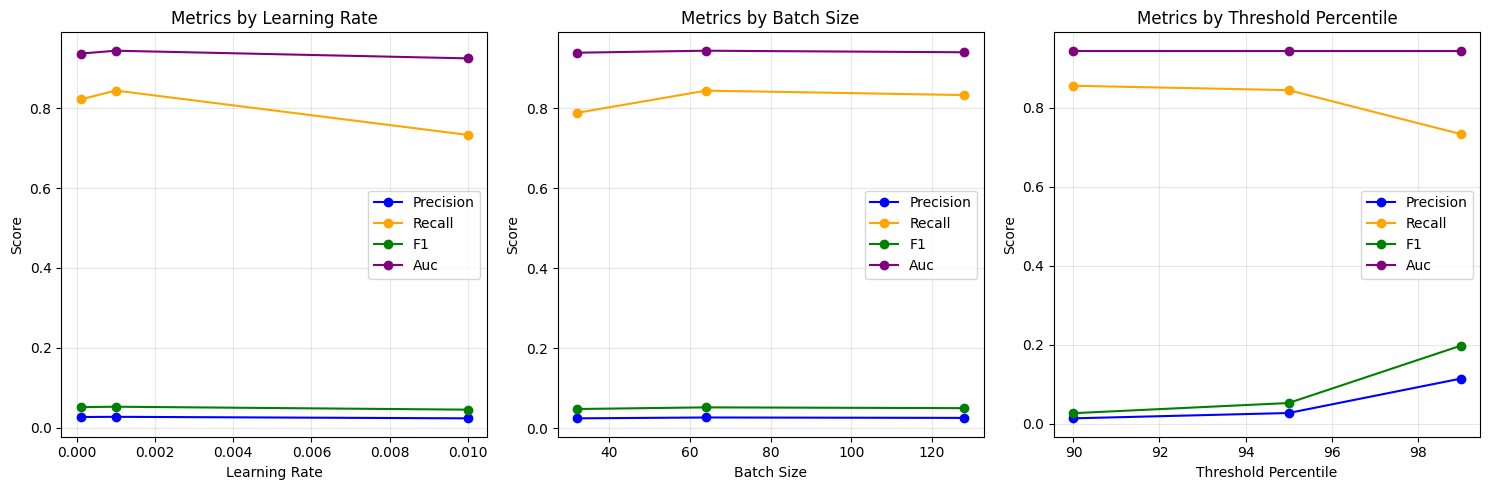


=== Best Parameters ===
Learning Rate: 0.001 (F1=0.0523)
Batch Size: 64 (F1=0.0523)
Threshold Percentile: 99 (F1=0.1973)


In [27]:
def tune_hyperparameters(X, y):
    
    # Create datasets
    train_dataset = AnomalyDataset(X_train)
    test_dataset = AnomalyDataset(X_test)
    
    # Parameter values to test
    params = {
        'learning_rate': [0.0001, 0.001, 0.01],
        'batch_size': [32, 64, 128],
        'threshold_percentile': [90, 95, 99]
    }
    
    # Default values
    defaults = {'learning_rate': 0.001, 'batch_size': 64, 'threshold_percentile': 95}
    
    # Results storage
    results = {param: {'values': [], 'f1': [], 'precision': [], 'recall': [], 'auc': []} 
               for param in params}
    
    # Function to train and evaluate
    def train_and_evaluate(lr, bs, tp_func):
        # Create model
        model = SimpleAutoencoder(input_dim=X_train.shape[1])
        
        # Set up trainer
        trainer = AnomalyTrainer(
            model=model,
            args=TrainingArguments(
                output_dir="./tuning",
                num_train_epochs=1,
                per_device_train_batch_size=bs,
                learning_rate=lr,
                save_strategy="no",
                eval_strategy="epoch",
                report_to="none",
                disable_tqdm=False,
                logging_steps=100
            ),
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
        )
        
        # Train model
        trainer.train()
        
        # Get reconstruction errors
        train_errors = trainer.predict(train_dataset).predictions
        test_errors = trainer.predict(test_dataset).predictions
        
        # Get threshold value
        if callable(tp_func):
            threshold = tp_func(train_errors)
        else:
            threshold = np.percentile(train_errors, tp_func)
        
        # Make predictions
        y_pred = (test_errors > threshold).astype(int)
        
        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, average='binary', zero_division=0)
        auc_score = roc_auc_score(y_test, test_errors)
        
        return precision, recall, f1, auc_score
    
    # Test learning rates
    print("\nTesting learning rates...")
    for lr in params['learning_rate']:
        print(f"Learning rate: {lr}")
        precision, recall, f1, auc_score = train_and_evaluate(
            lr, defaults['batch_size'], defaults['threshold_percentile'])
        
        results['learning_rate']['values'].append(lr)
        results['learning_rate']['precision'].append(precision)
        results['learning_rate']['recall'].append(recall)
        results['learning_rate']['f1'].append(f1)
        results['learning_rate']['auc'].append(auc_score)
        
        print(f"Metrics: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}, AUC={auc_score:.4f}")
    
    # Test batch sizes
    print("\nTesting batch sizes...")
    for bs in params['batch_size']:
        print(f"Batch size: {bs}")
        precision, recall, f1, auc_score = train_and_evaluate(
            defaults['learning_rate'], bs, defaults['threshold_percentile'])
        
        results['batch_size']['values'].append(bs)
        results['batch_size']['precision'].append(precision)
        results['batch_size']['recall'].append(recall)
        results['batch_size']['f1'].append(f1)
        results['batch_size']['auc'].append(auc_score)
        
        print(f"Metrics: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}, AUC={auc_score:.4f}")
    
    # Test threshold percentiles (reuse model)
    print("\nTesting threshold percentiles...")
    model = SimpleAutoencoder(input_dim=X_train.shape[1])
    
    trainer = AnomalyTrainer(
        model=model,
        args=TrainingArguments(
            output_dir="./tuning_threshold",
            num_train_epochs=1,
            per_device_train_batch_size=defaults['batch_size'],
            learning_rate=defaults['learning_rate'],
            save_strategy="no",
            eval_strategy="epoch",
            report_to="none",
            disable_tqdm=False
        ),
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
    )
    
    trainer.train()
    
    # Get errors once for all threshold tests
    train_errors = trainer.predict(train_dataset).predictions
    test_errors = trainer.predict(test_dataset).predictions
    
    for tp in params['threshold_percentile']:
        print(f"Threshold percentile: {tp}")
        threshold = np.percentile(train_errors, tp)
        y_pred = (test_errors > threshold).astype(int)
        
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, average='binary', zero_division=0)
        auc_score = roc_auc_score(y_test, test_errors)
        
        results['threshold_percentile']['values'].append(tp)
        results['threshold_percentile']['precision'].append(precision)
        results['threshold_percentile']['recall'].append(recall)
        results['threshold_percentile']['f1'].append(f1)
        results['threshold_percentile']['auc'].append(auc_score)
        
        print(f"Metrics: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}, AUC={auc_score:.4f}")
    
    # Find best parameters
    best_params = {}
    for param in params:
        best_idx = np.argmax(results[param]['f1'])
        best_params[param] = {
            'value': results[param]['values'][best_idx],
            'f1': results[param]['f1'][best_idx]
        }
    
    # Plot results
    plot_param_results(results)
    
    # Print optimal configuration
    print("\n=== Best Parameters ===")
    for param, info in best_params.items():
        print(f"{param.replace('_', ' ').title()}: {info['value']} (F1={info['f1']:.4f})")
    
    # Return optimal configuration
    return {
        'learning_rate': best_params['learning_rate']['value'],
        'batch_size': int(best_params['batch_size']['value']),
        'threshold_percentile': best_params['threshold_percentile']['value']
    }, results

def plot_param_results(results):
    """Simple line plots for hyperparameter tuning results."""
    metrics = ['precision', 'recall', 'f1', 'auc']
    colors = ['blue', 'orange', 'green', 'purple']
    
    plt.figure(figsize=(15, 5))
    
    # Plot each parameter in its own subplot
    for i, param in enumerate(['learning_rate', 'batch_size', 'threshold_percentile']):
        plt.subplot(1, 3, i+1)
        
        for j, metric in enumerate(metrics):
            plt.plot(
                results[param]['values'], 
                results[param][metric], 
                marker='o', 
                color=colors[j], 
                label=metric.capitalize()
            )
            
        plt.title(f'Metrics by {param.replace("_", " ").title()}')
        plt.xlabel(param.replace("_", " ").title())
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
optimal_params, results = tune_hyperparameters(X_combined, y_combined)

According to the hyperparameter tuning learning rate and batch size have minimal impact on the model and are already optimal. The only metric that could be improved out of the ones tested is setting a higher threshold, which might reduce the large amount of false positives presented previously, we will do so and run the model again.

Training fold 1/3...


Epoch,Training Loss,Validation Loss
1,0.388100,0.358357
2,0.336800,0.322670
3,0.311300,0.314454


Fold 1: Precision=0.1354, Recall=0.8165, F1=0.2322, AUC=0.9503
Training fold 2/3...


Epoch,Training Loss,Validation Loss
1,0.326800,0.321363
2,0.292500,0.293446
3,0.289700,0.288748


Fold 2: Precision=0.1342, Recall=0.8217, F1=0.2308, AUC=0.9663
Training fold 3/3...


Epoch,Training Loss,Validation Loss
1,0.326600,0.311835
2,0.289200,0.290103
3,0.297400,0.283602


Fold 3: Precision=0.1285, Recall=0.8038, F1=0.2216, AUC=0.9648

Cross-validation summary:
Precision: 0.1327 ± 0.0030
Recall: 0.8140 ± 0.0075
F1 Score: 0.2282 ± 0.0047
AUC: 0.9605 ± 0.0072


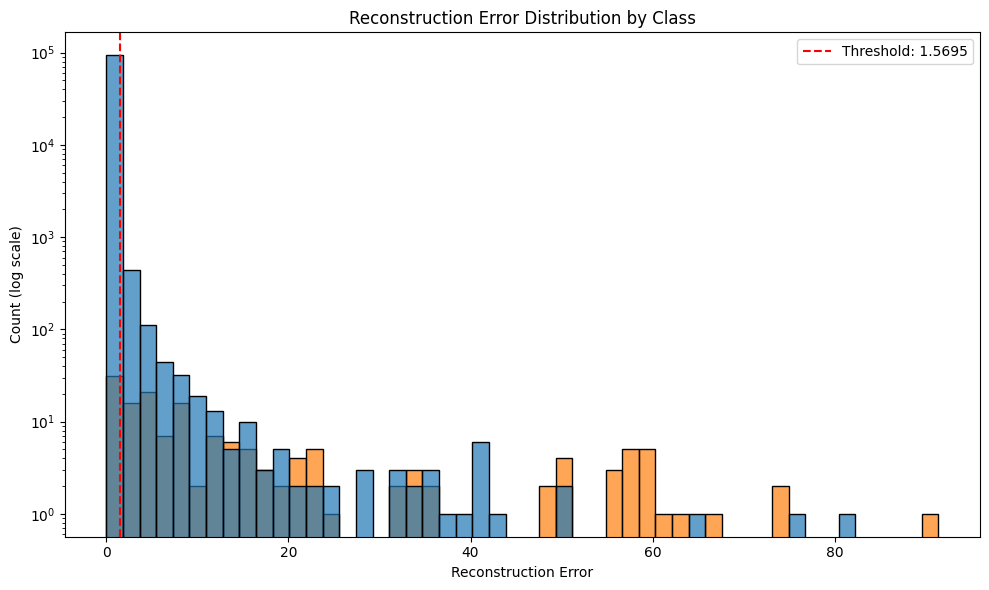

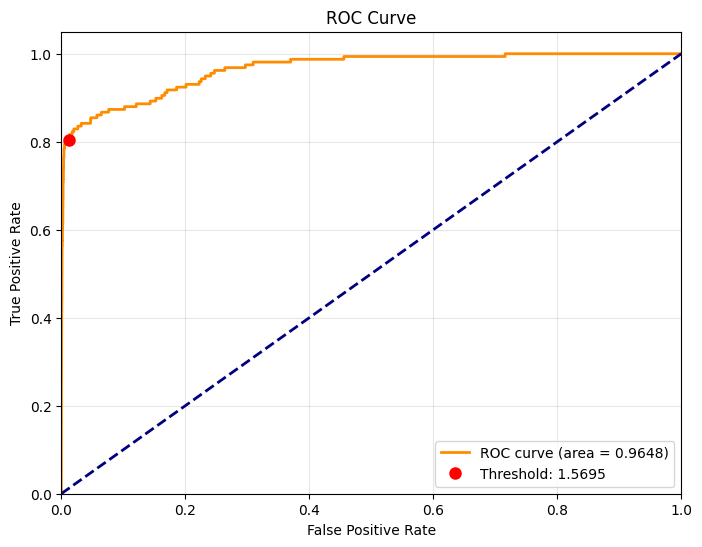

In [30]:
# Define the autoencoder model
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_dim=28, encoding_dim=10):
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 20),
            nn.ReLU(),
            nn.Linear(20, encoding_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 20),
            nn.ReLU(),
            nn.Linear(20, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        reconstruction_error = torch.mean((reconstructed - x) ** 2, dim=1)
        return {
            'reconstructed': reconstructed,
            'reconstruction_error': reconstruction_error
        }

# Dataset class
class AnomalyDataset(Dataset):
    def __init__(self, features):
        if isinstance(features, pd.DataFrame):
            self.features = torch.tensor(features.values, dtype=torch.float32)
        else:
            self.features = torch.tensor(features, dtype=torch.float32)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return {'x': self.features[idx]}

# Custom trainer
class AnomalyTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        x = inputs['x']
        outputs = model(x)
        loss = torch.mean((outputs['reconstructed'] - x) ** 2)
        return (loss, outputs) if return_outputs else loss
    
    def prediction_step(self, model, inputs, prediction_loss_only=False, ignore_keys=None):
        x = inputs['x']
        with torch.no_grad():
            outputs = model(x)
            loss = torch.mean((outputs['reconstructed'] - x) ** 2)
        return loss, outputs['reconstruction_error'], None

# Main cross-validation function
def run_anomaly_detection_cv(X, y, n_splits=3, epochs=3):
    """Run anomaly detection with cross-validation only"""
    
    # Initialize stratified k-fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = {'precision': [], 'recall': [], 'f1': [], 'auc': [], 'threshold': []}
    best_fold_data = {}
    
    # Loop through folds
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"Training fold {fold+1}/{n_splits}...")
        
        # Split data
        if hasattr(X, 'iloc'):  # DataFrame
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        else:  # numpy array
            X_train, X_test = X[train_idx], X[test_idx]
            
        if hasattr(y, 'iloc'):  # Series
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        else:  # numpy array
            y_train, y_test = y[train_idx], y[test_idx]
        
        # Create datasets
        train_dataset = AnomalyDataset(X_train)
        test_dataset = AnomalyDataset(X_test)
        
        # Create model and trainer
        model = SimpleAutoencoder(input_dim=X_train.shape[1])
        
        # Training arguments
        args = TrainingArguments(
            output_dir=f"./anomaly_fold_{fold}",
            num_train_epochs=epochs,
            per_device_train_batch_size=64,
            learning_rate=0.001,
            save_strategy="no",
            eval_strategy="epoch",
            report_to="none",
            disable_tqdm=False
        )
        
        trainer = AnomalyTrainer(
            model=model,
            args=args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
        )
        trainer.train()
        
        # Get reconstruction errors
        train_outputs = trainer.predict(train_dataset)
        test_outputs = trainer.predict(test_dataset)
        train_errors = train_outputs.predictions
        test_errors = test_outputs.predictions
        
        # Find threshold (99th percentile of training errors)
        threshold = np.percentile(train_errors, 99)
        
        # Make predictions
        y_pred = (test_errors > threshold).astype(int)
        
        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, average='binary')
        auc_score = roc_auc_score(y_test, test_errors)
        
        # Store results
        results['precision'].append(precision)
        results['recall'].append(recall)
        results['f1'].append(f1)
        results['auc'].append(auc_score)
        results['threshold'].append(threshold)
        
        # Save best fold data for visualization
        if fold == n_splits - 1 or auc_score > results['auc'][-1] if fold > 0 else 0:
            best_fold_data = {
                'errors': test_errors,
                'y_true': y_test,
                'threshold': threshold
            }
        
        print(f"Fold {fold+1}: Precision={precision:.4f}, Recall={recall:.4f}, " 
              f"F1={f1:.4f}, AUC={auc_score:.4f}")
    
    # Calculate summary statistics
    summary = {}
    for metric in results:
        summary[f'{metric}_mean'] = np.mean(results[metric])
        summary[f'{metric}_std'] = np.std(results[metric])
    print("\nCross-validation summary:")
    print(f"Precision: {summary['precision_mean']:.4f} ± {summary['precision_std']:.4f}")
    print(f"Recall: {summary['recall_mean']:.4f} ± {summary['recall_std']:.4f}")
    print(f"F1 Score: {summary['f1_mean']:.4f} ± {summary['f1_std']:.4f}")
    print(f"AUC: {summary['auc_mean']:.4f} ± {summary['auc_std']:.4f}")
    visualize_results(results, summary, best_fold_data)
    return results, summary

def visualize_results(results, summary, best_fold_data):
    
    # Error distribution
    if best_fold_data:
        # Plot histogram
        plt.figure(figsize=(10, 6))
        results_df = pd.DataFrame({
            'Reconstruction_Error': best_fold_data['errors'],
            'Class': ['Anomaly' if c == 1 else 'Normal' for c in best_fold_data['y_true']]
        })
        
        sns.histplot(data=results_df, x='Reconstruction_Error', hue='Class',
                    bins=50, alpha=0.7, log_scale=(False, True))
        
        plt.axvline(x=best_fold_data['threshold'], color='red', linestyle='--', 
                   label=f'Threshold: {best_fold_data["threshold"]:.4f}')
        
        plt.title('Reconstruction Error Distribution by Class')
        plt.xlabel('Reconstruction Error')
        plt.ylabel('Count (log scale)')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # ROC curve
        fpr, tpr, thresholds = roc_curve(best_fold_data['y_true'], best_fold_data['errors'])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        idx = (np.abs(thresholds - best_fold_data['threshold'])).argmin()
        plt.plot(fpr[idx], tpr[idx], 'ro', markersize=8, 
                 label=f'Threshold: {best_fold_data["threshold"]:.4f}')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()

# Combine train and test data
X_combined = pd.concat([X_train, X_test]) if isinstance(X_train, pd.DataFrame) else np.vstack([X_train, X_test])
y_combined = pd.concat([y_train, y_test]) if isinstance(y_train, pd.Series) else np.concatenate([y_train, y_test])

# Run cross-validation 
results, summary = run_anomaly_detection_cv(X_combined, y_combined)

The model produces a lot less false positives this time around due to the higher threshold value. Precision has been improved by 355% and F1 score has been improved by 305%. Meanwhile AUC has not changed and recall only received a 6,8% decrease. This means that now 13% of all flagged transactions are fraud rather than 3% as it was previously which is a 450% improvement. We do catch 81,4% of fraud cases now in comparison to 87,3% but that is a comprormise worth taking by most banks.

Next we will try implementing the Deep SVDD model. This model has no encoder or decoder but will instead create a feed-forward network with two hidden layers. Deep SVDD creates a center point which represents an average transaction and then calculates distance from that center point for each transaction, points far from the center are considered to be anomalies.

Training fold 1/3...


Epoch,Training Loss,Validation Loss
1,0.001900,0.001902
2,0.001900,0.001882
3,0.001900,0.001874


Fold 1: Precision=0.0739, Recall=0.4430, F1=0.1267, AUC=0.9289
Training fold 2/3...


Epoch,Training Loss,Validation Loss
1,0.001000,0.000996
2,0.000500,0.000491
3,0.000500,0.000485


Fold 2: Precision=0.1395, Recall=0.7898, F1=0.2371, AUC=0.9364
Training fold 3/3...


Epoch,Training Loss,Validation Loss
1,0.002400,0.002343
2,0.002300,0.002317
3,0.002300,0.002249


Fold 3: Precision=0.0071, Recall=0.0443, F1=0.0123, AUC=0.8424

Cross-validation summary:
Precision: 0.0735 ± 0.0540
Recall: 0.4257 ± 0.3046
F1 Score: 0.1254 ± 0.0918
AUC: 0.9026 ± 0.0427


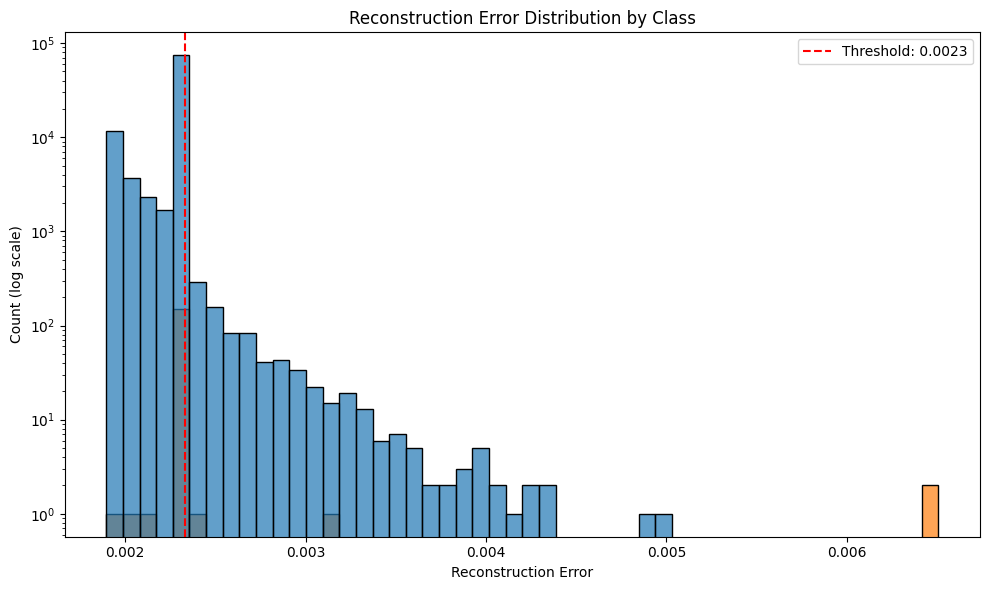

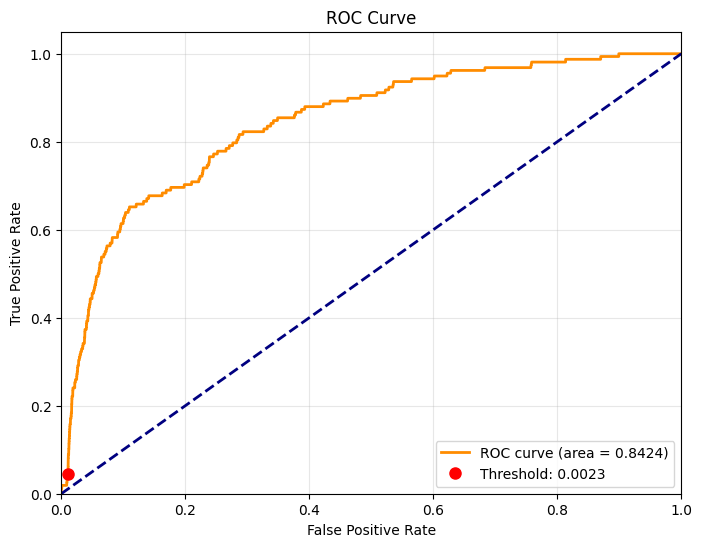

In [10]:
# Define the Deep SVDD model for anomaly detection
class DeepSVDD(nn.Module):
    def __init__(self, input_dim=28, hidden_dims=[20, 10]):
        super().__init__()
        
        # Network architecture to map to the SVDD space
        layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, dim))
            layers.append(nn.ReLU())
            prev_dim = dim
            
        self.network = nn.Sequential(*layers)
        self.center = None  # Will be set during training
        
    def forward(self, x):
        # Get the representation in the SVDD space
        representation = self.network(x)
        
        # If center is not set, use this batch's mean as temporary center
        if self.center is None:
            with torch.no_grad():
                self.center = torch.mean(representation, dim=0)
        
        # Calculate distance to center (anomaly score)
        reconstruction_error = torch.sum((representation - self.center) ** 2, dim=1)
        
        # For compatibility with existing code, return both the representation 
        # and the error (distance to center)
        return {
            'reconstructed': x,  # Not actually reconstructing, just for interface compatibility
            'reconstruction_error': reconstruction_error
        }

# Dataset class
class AnomalyDataset(Dataset):
    def __init__(self, features):
        if isinstance(features, pd.DataFrame):
            self.features = torch.tensor(features.values, dtype=torch.float32)
        else:
            self.features = torch.tensor(features, dtype=torch.float32)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return {'x': self.features[idx]}

# Custom trainer
class AnomalyTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        x = inputs['x']
        outputs = model(x)
        loss = torch.mean(outputs['reconstruction_error'])
        return (loss, outputs) if return_outputs else loss
    
    def prediction_step(self, model, inputs, prediction_loss_only=False, ignore_keys=None):
        x = inputs['x']
        with torch.no_grad():
            outputs = model(x)
            loss = torch.mean(outputs['reconstruction_error'])
        return loss, outputs['reconstruction_error'], None

# Main cross-validation function
def run_anomaly_detection_cv(X, y, n_splits=3, epochs=3):
    """Run anomaly detection with cross-validation only"""
    
    # Initialize stratified k-fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = {'precision': [], 'recall': [], 'f1': [], 'auc': [], 'threshold': []}
    best_fold_data = {}
    
    # Loop through folds
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"Training fold {fold+1}/{n_splits}...")
        
        # Split data
        if hasattr(X, 'iloc'):  # DataFrame
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        else:  # numpy array
            X_train, X_test = X[train_idx], X[test_idx]
            
        if hasattr(y, 'iloc'):  # Series
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        else:  # numpy array
            y_train, y_test = y[train_idx], y[test_idx]
        
        # Create datasets
        train_dataset = AnomalyDataset(X_train)
        test_dataset = AnomalyDataset(X_test)
        
        # Create model and trainer
        model = DeepSVDD(input_dim=X_train.shape[1])
        
        # Training arguments
        args = TrainingArguments(
            output_dir=f"./anomaly_fold_{fold}",
            num_train_epochs=epochs,
            per_device_train_batch_size=64,
            learning_rate=0.001,
            save_strategy="no",
            eval_strategy="epoch",
            report_to="none",
            disable_tqdm=False
        )
        
        trainer = AnomalyTrainer(
            model=model,
            args=args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
        )
        trainer.train()
        
        # Get reconstruction errors
        train_outputs = trainer.predict(train_dataset)
        test_outputs = trainer.predict(test_dataset)
        train_errors = train_outputs.predictions
        test_errors = test_outputs.predictions
        
        # Find threshold (99th percentile of training errors)
        threshold = np.percentile(train_errors, 99)
        
        # Make predictions
        y_pred = (test_errors > threshold).astype(int)
        
        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, average='binary')
        auc_score = roc_auc_score(y_test, test_errors)
        
        # Store results
        results['precision'].append(precision)
        results['recall'].append(recall)
        results['f1'].append(f1)
        results['auc'].append(auc_score)
        results['threshold'].append(threshold)
        
        # Save best fold data for visualization
        if fold == n_splits - 1 or auc_score > results['auc'][-1] if fold > 0 else 0:
            best_fold_data = {
                'errors': test_errors,
                'y_true': y_test,
                'threshold': threshold
            }
        
        print(f"Fold {fold+1}: Precision={precision:.4f}, Recall={recall:.4f}, " 
              f"F1={f1:.4f}, AUC={auc_score:.4f}")
    
    # Calculate summary statistics
    summary = {}
    for metric in results:
        summary[f'{metric}_mean'] = np.mean(results[metric])
        summary[f'{metric}_std'] = np.std(results[metric])
    print("\nCross-validation summary:")
    print(f"Precision: {summary['precision_mean']:.4f} ± {summary['precision_std']:.4f}")
    print(f"Recall: {summary['recall_mean']:.4f} ± {summary['recall_std']:.4f}")
    print(f"F1 Score: {summary['f1_mean']:.4f} ± {summary['f1_std']:.4f}")
    print(f"AUC: {summary['auc_mean']:.4f} ± {summary['auc_std']:.4f}")
    visualize_results(results, summary, best_fold_data)
    return results, summary

def visualize_results(results, summary, best_fold_data):
    
    # Error distribution
    if best_fold_data:
        # Plot histogram
        plt.figure(figsize=(10, 6))
        results_df = pd.DataFrame({
            'Reconstruction_Error': best_fold_data['errors'],
            'Class': ['Anomaly' if c == 1 else 'Normal' for c in best_fold_data['y_true']]
        })
        
        sns.histplot(data=results_df, x='Reconstruction_Error', hue='Class',
                    bins=50, alpha=0.7, log_scale=(False, True))
        
        plt.axvline(x=best_fold_data['threshold'], color='red', linestyle='--', 
                   label=f'Threshold: {best_fold_data["threshold"]:.4f}')
        
        plt.title('Reconstruction Error Distribution by Class')
        plt.xlabel('Reconstruction Error')
        plt.ylabel('Count (log scale)')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # ROC curve
        fpr, tpr, thresholds = roc_curve(best_fold_data['y_true'], best_fold_data['errors'])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        idx = (np.abs(thresholds - best_fold_data['threshold'])).argmin()
        plt.plot(fpr[idx], tpr[idx], 'ro', markersize=8, 
                 label=f'Threshold: {best_fold_data["threshold"]:.4f}')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()

# Combine train and test data
X_combined = pd.concat([X_train, X_test]) if isinstance(X_train, pd.DataFrame) else np.vstack([X_train, X_test])
y_combined = pd.concat([y_train, y_test]) if isinstance(y_train, pd.Series) else np.concatenate([y_train, y_test])

# Run cross-validation 
results, summary = run_anomaly_detection_cv(X_combined, y_combined)

The Deep SVDD model performs significantly worse than the autoencoder, catching only 42,6% of fraud cases. It also performs around 80-90% worse across all metrics other than AUC which is a 6% decrease. This might be the result of bad hyperparameter tuning so we will perform the same process as before.


Testing learning rates...
Learning rate: 0.0001


Epoch,Training Loss,Validation Loss
1,0.013200,0.013528


Metrics: Precision=0.0239, Recall=0.7556, F1=0.0464, AUC=0.9242
Learning rate: 0.001


Epoch,Training Loss,Validation Loss
1,0.001500,0.001455


Metrics: Precision=0.0263, Recall=0.8111, F1=0.0509, AUC=0.9257
Learning rate: 0.01


Epoch,Training Loss,Validation Loss
1,0.003900,0.003922


Metrics: Precision=0.0047, Recall=0.1444, F1=0.0091, AUC=0.5458

Testing batch sizes...
Batch size: 32


Epoch,Training Loss,Validation Loss
1,0.000800,0.000757


Metrics: Precision=0.0249, Recall=0.7778, F1=0.0482, AUC=0.9063
Batch size: 64


Epoch,Training Loss,Validation Loss
1,0.001500,0.001455


Metrics: Precision=0.0263, Recall=0.8111, F1=0.0509, AUC=0.9257
Batch size: 128


Epoch,Training Loss,Validation Loss
1,0.003700,0.003637


Metrics: Precision=0.0217, Recall=0.7222, F1=0.0422, AUC=0.8988

Testing threshold percentiles...


Epoch,Training Loss,Validation Loss
1,0.001500,0.001455


Threshold percentile: 90
Metrics: Precision=0.0133, Recall=0.8222, F1=0.0261, AUC=0.9257
Threshold percentile: 95
Metrics: Precision=0.0263, Recall=0.8111, F1=0.0509, AUC=0.9257
Threshold percentile: 99
Metrics: Precision=0.1169, Recall=0.7667, F1=0.2029, AUC=0.9257


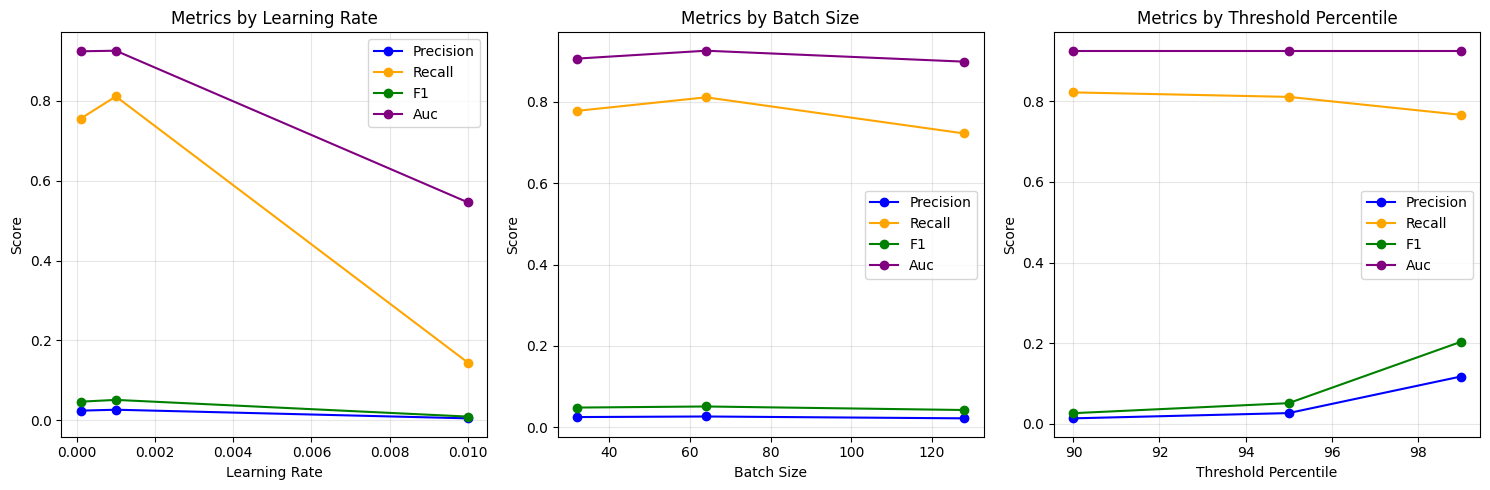


=== Best Parameters ===
Learning Rate: 0.001 (F1=0.0509)
Batch Size: 64 (F1=0.0509)
Threshold Percentile: 99 (F1=0.2029)


In [12]:
def tune_hyperparameters(X, y):
    
    # Create datasets
    train_dataset = AnomalyDataset(X_train)
    test_dataset = AnomalyDataset(X_test)
    
    # Parameter values to test
    params = {
        'learning_rate': [0.0001, 0.001, 0.01],
        'batch_size': [32, 64, 128],
        'threshold_percentile': [90, 95, 99]
    }
    
    # Default values
    defaults = {'learning_rate': 0.001, 'batch_size': 64, 'threshold_percentile': 95}
    
    # Results storage
    results = {param: {'values': [], 'f1': [], 'precision': [], 'recall': [], 'auc': []} 
               for param in params}
    
    # Function to train and evaluate
    def train_and_evaluate(lr, bs, tp_func):
        # Create model
        model = DeepSVDD(input_dim=X_train.shape[1])
        
        # Set up trainer
        trainer = AnomalyTrainer(
            model=model,
            args=TrainingArguments(
                output_dir="./tuning",
                num_train_epochs=1,
                per_device_train_batch_size=bs,
                learning_rate=lr,
                save_strategy="no",
                eval_strategy="epoch",
                report_to="none",
                disable_tqdm=False,
                logging_steps=100
            ),
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
        )
        
        # Train model
        trainer.train()
        
        # Get reconstruction errors
        train_errors = trainer.predict(train_dataset).predictions
        test_errors = trainer.predict(test_dataset).predictions
        
        # Get threshold value
        if callable(tp_func):
            threshold = tp_func(train_errors)
        else:
            threshold = np.percentile(train_errors, tp_func)
        
        # Make predictions
        y_pred = (test_errors > threshold).astype(int)
        
        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, average='binary', zero_division=0)
        auc_score = roc_auc_score(y_test, test_errors)
        
        return precision, recall, f1, auc_score
    
    # Test learning rates
    print("\nTesting learning rates...")
    for lr in params['learning_rate']:
        print(f"Learning rate: {lr}")
        precision, recall, f1, auc_score = train_and_evaluate(
            lr, defaults['batch_size'], defaults['threshold_percentile'])
        
        results['learning_rate']['values'].append(lr)
        results['learning_rate']['precision'].append(precision)
        results['learning_rate']['recall'].append(recall)
        results['learning_rate']['f1'].append(f1)
        results['learning_rate']['auc'].append(auc_score)
        
        print(f"Metrics: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}, AUC={auc_score:.4f}")
    
    # Test batch sizes
    print("\nTesting batch sizes...")
    for bs in params['batch_size']:
        print(f"Batch size: {bs}")
        precision, recall, f1, auc_score = train_and_evaluate(
            defaults['learning_rate'], bs, defaults['threshold_percentile'])
        
        results['batch_size']['values'].append(bs)
        results['batch_size']['precision'].append(precision)
        results['batch_size']['recall'].append(recall)
        results['batch_size']['f1'].append(f1)
        results['batch_size']['auc'].append(auc_score)
        
        print(f"Metrics: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}, AUC={auc_score:.4f}")
    
    # Test threshold percentiles (reuse model)
    print("\nTesting threshold percentiles...")
    model = DeepSVDD(input_dim=X_train.shape[1])
    
    trainer = AnomalyTrainer(
        model=model,
        args=TrainingArguments(
            output_dir="./tuning_threshold",
            num_train_epochs=1,
            per_device_train_batch_size=defaults['batch_size'],
            learning_rate=defaults['learning_rate'],
            save_strategy="no",
            eval_strategy="epoch",
            report_to="none",
            disable_tqdm=False
        ),
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
    )
    
    trainer.train()
    
    # Get errors once for all threshold tests
    train_errors = trainer.predict(train_dataset).predictions
    test_errors = trainer.predict(test_dataset).predictions
    
    for tp in params['threshold_percentile']:
        print(f"Threshold percentile: {tp}")
        threshold = np.percentile(train_errors, tp)
        y_pred = (test_errors > threshold).astype(int)
        
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, average='binary', zero_division=0)
        auc_score = roc_auc_score(y_test, test_errors)
        
        results['threshold_percentile']['values'].append(tp)
        results['threshold_percentile']['precision'].append(precision)
        results['threshold_percentile']['recall'].append(recall)
        results['threshold_percentile']['f1'].append(f1)
        results['threshold_percentile']['auc'].append(auc_score)
        
        print(f"Metrics: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}, AUC={auc_score:.4f}")
    
    # Find best parameters
    best_params = {}
    for param in params:
        best_idx = np.argmax(results[param]['f1'])
        best_params[param] = {
            'value': results[param]['values'][best_idx],
            'f1': results[param]['f1'][best_idx]
        }
    
    # Plot results
    plot_param_results(results)
    
    # Print optimal configuration
    print("\n=== Best Parameters ===")
    for param, info in best_params.items():
        print(f"{param.replace('_', ' ').title()}: {info['value']} (F1={info['f1']:.4f})")
    
    # Return optimal configuration
    return {
        'learning_rate': best_params['learning_rate']['value'],
        'batch_size': int(best_params['batch_size']['value']),
        'threshold_percentile': best_params['threshold_percentile']['value']
    }, results

def plot_param_results(results):
    """Simple line plots for hyperparameter tuning results."""
    metrics = ['precision', 'recall', 'f1', 'auc']
    colors = ['blue', 'orange', 'green', 'purple']
    
    plt.figure(figsize=(15, 5))
    
    # Plot each parameter in its own subplot
    for i, param in enumerate(['learning_rate', 'batch_size', 'threshold_percentile']):
        plt.subplot(1, 3, i+1)
        
        for j, metric in enumerate(metrics):
            plt.plot(
                results[param]['values'], 
                results[param][metric], 
                marker='o', 
                color=colors[j], 
                label=metric.capitalize()
            )
            
        plt.title(f'Metrics by {param.replace("_", " ").title()}')
        plt.xlabel(param.replace("_", " ").title())
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
optimal_params, results = tune_hyperparameters(X_combined, y_combined)

In conclusion the optimal hyperparameters turned out to be the same as the ones we used so it seems that Deep SVDD is a worse model than the autoencoder to use for this dataset. Autoencoders are very good at finding small discrepancies in imbalanced datasets such as for this type of fraud detection, especially for datasets that have gone through PCA. The huge difference is still surprising though and I believed originally that Deep SVDD would perform better. Our autoencoder implementation was fairly rudimentary so I believe a more complicated one that had additional features such as adding regularization between layers to prevent overfitting and adding anomaly-weighted loss functions that would add more weight to transactions with higher reconstruction error rates.

Claude 3.7 was used for some troubleshooting.

Dal Pozzolo, A., Caelen, O., Johnson, R. A., & Bontempi, G. (2015). Credit Card Fraud Detection: A Realistic Modeling and a Novel Learning Strategy [Data set]. IEEE Transactions on Neural Networks and Learning Systems. Retrieved from https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud